<font size="2"> [github.com/jankoslavic/pypinm](http://github.com/jankoslavic/pypinm)</font>

<center>
<img width=300 src="./fig/ladisk.png">
<br>
<font size="7" color="f00e0e" face="garamond"><b>Sistemi linearnih algebrajskih enačb (2)</b></font>
<br><br>
<font size="4">
[izr.prof. dr. Janko Slavič](http://www.ladisk.si/~slavic)
</font>
<br><br>
<font size="2">Marec 2017</font>
</center>

# Table of Contents
 <p><div class="lev1"><a href="#LU-razcep"><span class="toc-item-num">1&nbsp;&nbsp;</span>LU razcep</a></div><div class="lev2"><a href="#Doolittle-razcep"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Doolittle razcep</a></div><div class="lev2"><a href="#Teoretično-ozadje"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Teoretično ozadje</a></div><div class="lev2"><a href="#LU-razcep-povzetek"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>LU razcep povzetek</a></div><div class="lev2"><a href="#Uporaba-in-zaključki"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Uporaba in zaključki</a></div><div class="lev1"><a href="#Pivotiranje"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pivotiranje</a></div><div class="lev2"><a href="#Diagonalno-dominantna-matrika"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Diagonalno dominantna matrika</a></div><div class="lev2"><a href="#Gaussova-eliminacija-z-delnim-pivotiranjem"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Gaussova eliminacija z delnim pivotiranjem</a></div><div class="lev2"><a href="#LU-razcep-z-delnim-pivotiranjem"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LU razcep z delnim pivotiranjem</a></div><div class="lev1"><a href="#Modul-SciPy"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modul <code>SciPy</code></a></div><div class="lev1"><a href="#Inverz-matrik"><span class="toc-item-num">4&nbsp;&nbsp;</span>Inverz matrik</a></div><div class="lev1"><a href="#Psevdo-inverz---reševanje-predoločenih-sistemov"><span class="toc-item-num">5&nbsp;&nbsp;</span>Psevdo inverz - reševanje predoločenih sistemov</a></div><div class="lev1"><a href="#Iterativne-metode"><span class="toc-item-num">6&nbsp;&nbsp;</span>Iterativne metode</a></div><div class="lev2"><a href="#Gauss-Seidel-metoda"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Gauss-Seidel metoda</a></div><div class="lev2"><a href="#Zgled"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Zgled</a></div><div class="lev1"><a href="#Nekaj-vprašanj-za-razmislek!"><span class="toc-item-num">7&nbsp;&nbsp;</span>Nekaj vprašanj za razmislek!</a></div><div class="lev2"><a href="#Ekstra"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Ekstra</a></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sympy as sym
sym.init_printing()

# LU razcep

Kakor smo že zgoraj omenili, pri LU razcepu želimo matriko $\mathbf{A}$ zapisati kot:
$$\mathbf{A}=\mathbf{L}\,\mathbf{U},$$

kjer je $\mathbf{L}$ spodnja trikotna, $\mathbf{U}$ pa zgornja trikotna matrika. Tako definiran LU razcep pa ni enolično določen; za enoličnost, ga je potrebno dodatno omejiti. Tri najpogostejši LU razcepi so:

| Razcep| Omejitve|
|:-----:|:----:|
| | |
|Doolittle| $L_{ii}=1$|
|Crout|$U_{ii}=1$|
|Choleski| $\mathbf{L}=\mathbf{U}^{T}$|

## Doolittle razcep

Če namesto: 
$$\mathbf{A}\mathbf{x}=\mathbf{b}$$
rešujemo:
$$\mathbf{L}\underbrace{\mathbf{U}\mathbf{x}}_{\mathbf{y}}=\mathbf{b},$$
oziroma najprej:
$$\mathbf{L}\,\mathbf{y}=\mathbf{b}.$$
 
Do rešitve pridemo v treh korakih:
1. določimo matriki $\mathbf{L}$ in $\mathbf{U}$,
* iz $\mathbf{L}\,\mathbf{y}=\mathbf{b}$ določimo $\mathbf{y}$,
* iz $\mathbf{U}\,\mathbf{x}=\mathbf{y}$ določimo $\mathbf{x}$.

## Teoretično ozadje

Doolittle razcep si bomo pogledali na preprostem primeru in ugotovili, da je zelo povezan z *Gaussovo* eliminacijo.

Izpeljavo začnimo na primeru simbolno zapisanih matrik $\mathbf{L}$ in $\mathbf{U}$:

In [2]:
L21, L31, L32 = sym.symbols('L21, L31, L32')
U11, U12, U13, U22, U23, U33 = sym.symbols('U11, U12, U13, U22, U23, U33')
L = sym.Matrix([[  1,   0,  0],
                [L21,   1,  0],
                [L31, L32,  1]])
U = sym.Matrix([[U11, U12, U13],
                [  0, U22, U23],
                [  0,   0, U33]])

Splošna matrika koeficientov zapisana z $\mathbf{L}$ in  $\mathbf{U}$ torej je:

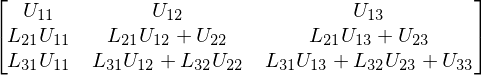

In [3]:
A = L*U
A

S pomočjo prve vrstice izvedimo sedaj Gaussovo eliminacijo druge in tretje; najprej si pripravimo matriko:

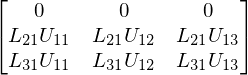

In [4]:
B = sym.Matrix([0*A[0,:],
                L21*A[0,:],
                L31*A[0,:]])
B

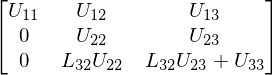

In [5]:
A1 = A-B
A1

Nadaljujemo z eliminacijo:

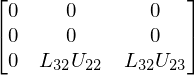

In [6]:
B = sym.Matrix([0*A1[1,:],
                0*A1[1,:],
              L32*A1[1,:]])
B

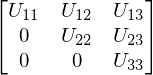

In [7]:
A2 = A1 - B
A2

Iz zgornje eliminacije ugotovimo:
1. matrika $\mathbf{U}$ je enaka matriki, ki jo dobimo, če izvedemo Gaussovo eliminacijo nad matriko koeficientov $\mathbf{A}$.
* izven diagonalni členi $\mathbf{L}$ predstavljajo vrednosti, ki smo jih uporabili pri Gaussovi eliminaciji.

Poglejmo si na primeru:

In [8]:
A = np.array([[8, -6, 3],
              [-6, 6, -6],
              [3, -6, 6]], dtype=float) 
b = np.array([-14, 36, 6], dtype=float)

In [9]:
(v, s) = A.shape
U = A.copy() 
L = np.zeros_like(A)
# eliminacija
for p, pivot_vrsta in enumerate(U[:-1]):
    for i, vrsta in enumerate(U[p+1:]):
        if pivot_vrsta[p]:
            m = vrsta[p]/pivot_vrsta[p]
            vrsta[p:] = vrsta[p:]-pivot_vrsta[p:]*m
            L[p+1+i, p] = m
    print('Korak: {:g}'.format(p))
    print(U)

Korak: 0
[[ 8.    -6.     3.   ]
 [ 0.     1.5   -3.75 ]
 [ 0.    -3.75   4.875]]
Korak: 1
[[ 8.   -6.    3.  ]
 [ 0.    1.5  -3.75]
 [ 0.    0.   -4.5 ]]


In [10]:
L

array([[ 0.   ,  0.   ,  0.   ],
       [-0.75 ,  0.   ,  0.   ],
       [ 0.375, -2.5  ,  0.   ]])

Dopolnimo $\mathbf{L}$:

In [11]:
for i in range(v):
    L[i, i] = 1.

In [12]:
L

array([[ 1.   ,  0.   ,  0.   ],
       [-0.75 ,  1.   ,  0.   ],
       [ 0.375, -2.5  ,  1.   ]])

In [13]:
b

array([-14.,  36.,   6.])

Sedaj lahko rešimo sistem enačb $\mathbf{L}\,\mathbf{y}=\mathbf{b}$:

In [14]:
# delna rešitev za lažje sledenje
y = np.zeros_like(b, )
for i, b_ in enumerate(b):
    y[i] = b_# / L[i, i]     

In [15]:
y

array([-14.,  36.,   6.])

In [16]:
# direktno vstavljanje
y = np.zeros_like(b)
for i, b_ in enumerate(b):
    y[i] = (b_ - np.dot(L[i, :i], y[:i]))    

In [17]:
y

array([-14. ,  25.5,  75. ])

Nadaljujemo z reševanjem $\mathbf{U}\,\mathbf{x}=\mathbf{y}$:

In [18]:
U

array([[ 8.  , -6.  ,  3.  ],
       [ 0.  ,  1.5 , -3.75],
       [ 0.  ,  0.  , -4.5 ]])

In [19]:
y

array([-14. ,  25.5,  75. ])

Spet gremo po korakih, najprej delno pravilno:

In [20]:
x = np.zeros_like(y)
for i in range(v-1, -1,-1):
    print(i)
    x[i] = y[i] / U[i, i]
x

2
1
0


array([ -1.75      ,  17.        , -16.66666667])

In [21]:
# obratno vstavljanje
x = np.zeros_like(b)
for i in range(v-1, -1,-1):
    x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
x

array([-14.        , -24.66666667, -16.66666667])

## LU razcep povzetek

V spodnjem zapisu v spominski prostor matrike $\mathbf{A}$ zapišemo tako $\mathbf{L}$, kot $\mathbf{U}$ matriko; to zapišemo takole $[\mathbf{L}\backslash \mathbf{U}]$

In [22]:
def LU_razcep(A):
    """ Vrne razcep A  kot ``[L\\U]`` """
    # eliminacija
    for p, pivot_vrsta in enumerate(A[:-1]):
        for i, vrsta in enumerate(A[p+1:]):
            if pivot_vrsta[p]!=0:
                m = vrsta[p]/pivot_vrsta[p]
                vrsta[p:] = vrsta[p:]-pivot_vrsta[p:]*m
                vrsta[p] = m
    return A

In [23]:
def LU_resitev(LU, b):
    """ Vrne vrednost x glede na ``[L\\U]x=b`` """
    y = np.zeros_like(b)
    x = np.zeros_like(b)
    for i, b_ in enumerate(b):
        y[i] = (b_ - np.dot(LU[i, :i], y[:i])) 
    v = len(b)
    for i in range(v-1, -1,-1):
        x[i] = (y[i] - np.dot(LU[i, i+1:], x[i+1:])) / LU[i, i]
    return x

Obe funkciji shranimo v ``orodja.py``.

## Uporaba in zaključki

Poglejmo si kratek zgled

In [24]:
import moduli.orodja as orodja

In [25]:
A = np.array([[8, -6, 3],
              [-6, 6, -6],
              [3, -6, 6]], dtype=float) # poskusite tukaj izpustiti dtype=float in 
b = np.array([-14, 36, 6], dtype=float)

In [26]:
LU = orodja.LU_razcep(A.copy())

In [27]:
LU

array([[ 8.   , -6.   ,  3.   ],
       [-0.75 ,  1.5  , -3.75 ],
       [ 0.375, -2.5  , -4.5  ]])

In [28]:
x = orodja.LU_resitev(LU, b)

In [29]:
x

array([-14.        , -24.66666667, -16.66666667])

Pomembna **prednost** LU razcepa je, da v kolikor se vektor konstant spremeni, ni potrebno ponovno izvesti samega razcepa (Gaussove eliminacije, ki zahteva največ numeričnih operacij - glejte prejšnje predavanje). Primer:

In [30]:
b2 = np.array([-1., 6., 7.])
x2 = orodja.LU_resitev(LU, b2)
x2

array([-4.33333333, -7.88888889, -4.55555556])

In [31]:
A.dot(x2)

array([-1.,  6.,  7.])

# Pivotiranje

Poglejmo si za motivacijo spodnji sistem enačb:

In [32]:
A = np.array([[8, -6, 3],
              [-6, 6, -6],
              [0, -6, 6]], dtype=float) # poskusite tukaj izpustiti dtype=float in preveriet rezultat
b = np.array([-14, 36, 6], dtype=float)

Izvedimo Gaussovo eliminacijo:

In [33]:
import moduli.orodja as orodja

In [34]:
Ab = orodja.gaussova_eliminacija(A,b, prikazi_korake=True)

Korak: 0
[[  8.    -6.     3.   -14.  ]
 [  0.     1.5   -3.75  25.5 ]
 [  0.    -6.     6.     6.  ]]
Korak: 1
[[   8.     -6.      3.    -14.  ]
 [   0.      1.5    -3.75   25.5 ]
 [   0.      0.     -9.    108.  ]]


In [35]:
x = orodja.gaussova_el_resitev(Ab)
x

array([ -7., -13., -12.])

In [36]:
np.linalg.solve(A, b)

array([ -7., -13., -12.])

Zamenjajmo sedaj prvo in zadnjo vrstico (opomba: tukaj uporabimo napredno rezanje, ki vrne kopijo podatkov, ne pogleda: [advanced indexing](http://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)):

In [37]:
A[[0], :], A[[2], :] = A[[2], :], A[[0], :]
A

array([[ 0., -6.,  6.],
       [-6.,  6., -6.],
       [ 8., -6.,  3.]])

In [38]:
b[[0]], b[[2]] = b[[2]], b[[0]]

In [39]:
Ab = orodja.gaussova_eliminacija(A,b, prikazi_korake=True)

Korak: 0
[[  0.  -6.   6.   6.]
 [ -6.   6.  -6.  36.]
 [  8.  -6.   3. -14.]]
Korak: 1
[[  0.  -6.   6.   6.]
 [ -6.   6.  -6.  36.]
 [  8.   0.  -3.  22.]]


Opazimo, da imamo težavo z 0 v prvi vrstici. Seveda pa se lahko zgodi, da vrednost ne bo 0, ampak bo zelo majhna vrednost $\varepsilon$ in v tem primeru bomo pri Gaussovi eliminaciji delili z zelo majhno vrednostjo (to pa bi povečevalo nagotovost).

Če bi pred Gaussovo eliminacijo ustrezno zamenjali vrstice (to imenujemo **pivotiranje vrstic**), potem teh težav ne bi imeli.

## Diagonalno dominantna matrika

Pravokotna matrika $\mathbf{A}$ dimenzije $n$ je **diagonalno dominantna**, če je diagonalni element večji kakor vsota absolutnih vrednosti ostalih elementov:
$$ |A_{ii}|> \sum_{j=1, j\ne i}^n |A_{ij}|$$
Lahko se pokaže, da sistem enačb $\mathbf{A}\,\mathbf{x}=\mathbf{b}$ pri katerem je matrika $\mathbf{A}$ diagonalno dominantna pivotirane vrstic ni potrebno.

## Gaussova eliminacija z delnim pivotiranjem

Tukaj si bomo pogledali Gaussovo eliminacijo z delnim pivotiranjem. To v bistvu pomeni, da preden se izvede eliminacija, se preveri ali je vrednost v izbranem stolpcu na diagonali res največja. Če vrednost ni največja, se diagonalno vrsto zamenja z vrsto (pod diagonalo) kjer je največja vrednost v stolpcu.

Spremenjen algoritem za Gaussovo eliminacijo z delnim pivotiranjem torej je:

In [40]:
def gaussova_eliminacija_pivotiranje(A, b, prikazi_korake=False):
    """ Vrne Gaussovo eliminacijo razširjene matrike koeficientov, uporabi delno pivotiranje

    :param A: matrika koeficientov
    :param b: vektor konstant
    :param prikazi_korake: ali izpišem posamezne korake
    :return Ab: razširjena matrika koeficientov
    """
    Ab = np.column_stack((A, b))
    for p in range(len(Ab)-1):
        p_max = np.argmax(np.abs(Ab[p:,p]))+p
        if p != p_max:
            Ab[[p], :], Ab[[p_max], :] = Ab[[p_max], :], Ab[[p], :]
        pivot_vrsta = Ab[p, :]                
        for vrsta in Ab[p + 1:]:
            if pivot_vrsta[p]:
                vrsta[p:] = vrsta[p:] - pivot_vrsta[p:] * vrsta[p] / pivot_vrsta[p]
        if prikazi_korake:
            print('Korak: {:g}'.format(p))
            print('Pivot vrsta:', pivot_vrsta)
            print(Ab)
    return Ab

In [41]:
A

array([[ 0., -6.,  6.],
       [-6.,  6., -6.],
       [ 8., -6.,  3.]])

In [42]:
Ab = gaussova_eliminacija_pivotiranje(A, b, prikazi_korake=True)

Korak: 0
Pivot vrsta: [  8.  -6.   3. -14.]
[[  8.    -6.     3.   -14.  ]
 [  0.     1.5   -3.75  25.5 ]
 [  0.    -6.     6.     6.  ]]
Korak: 1
Pivot vrsta: [ 0. -6.  6.  6.]
[[  8.    -6.     3.   -14.  ]
 [  0.    -6.     6.     6.  ]
 [  0.     0.    -2.25  27.  ]]


In [43]:
orodja.gaussova_el_resitev(Ab)

array([ -7., -13., -12.])

## LU razcep z delnim pivotiranjem

Delno pivotiranje pri LU razcepu implementiramo podobno kakor pri Gaussovi eliminaciji; edina večja razlika je, da moramo shraniti kako so se vrstice zamenjale in to potem posredovali tudi v funkcijo za rešitev. Implementacijo shranimo v ``orodja.py``.

In [44]:
def LU_razcep_pivotiranje(A, prikazi_korake=False):
    """ Vrne razcep LU matriko in vektor zamenjanih vrstic pivotiranje, uporabi delno pivotiranje

    :param A:               matrika koeficientov
    :param prikazi_korake:  izpišem posamezne korake
    :return LU:             LU matrika
    :return pivotiranje:    vektor zamenjave vrstic (pomembno pri iskanju rešitve)    
    """
    LU = A.copy()
    pivotiranje = np.arange(len(A))
    for p in range(len(LU)-1):
        p_max = np.argmax(np.abs(LU[p:,p]))+p
        if p != p_max:
            LU[[p], :], LU[[p_max], :] = LU[[p_max], :], LU[[p], :]
            pivotiranje[p], pivotiranje[p_max] = pivotiranje[p_max], pivotiranje[p]
        pivot_vrsta = LU[p, :]                
        for vrsta in LU[p + 1:]:
            if pivot_vrsta[p]:
                m = vrsta[p] / pivot_vrsta[p]
                vrsta[p:] = vrsta[p:] - pivot_vrsta[p:] * m
                vrsta[p] = m
        if prikazi_korake:
            print('Korak: {:g}'.format(p))
            print('Pivot vrsta:', pivot_vrsta)
            print(LU)
    return LU, pivotiranje

In [45]:
A = np.array([[0, -6, 6],
              [-6, 6, -6],
              [8, -6, 3]], dtype=float) # poskusite tukaj izpustiti dtype=float in 
b = np.array([-14, 36, 6], dtype=float)

In [46]:
lu, piv = LU_razcep_pivotiranje(A, prikazi_korake=True)

Korak: 0
Pivot vrsta: [ 8. -6.  3.]
[[ 8.   -6.    3.  ]
 [-0.75  1.5  -3.75]
 [ 0.   -6.    6.  ]]
Korak: 1
Pivot vrsta: [ 0. -6.  6.]
[[ 8.   -6.    3.  ]
 [ 0.   -6.    6.  ]
 [-0.75 -0.25 -2.25]]


In [47]:
piv

array([2, 0, 1])

In [48]:
r = orodja.LU_resitev_pivotiranje(lu, b, piv)
r

array([ -3.66666667, -14.11111111, -16.44444444])

In [49]:
np.linalg.solve(A,b)

array([ -3.66666667, -14.11111111, -16.44444444])

In [50]:
b_preverjanje = A.dot(r)
b_preverjanje

array([-14.,  36.,   6.])

In [51]:
b

array([-14.,  36.,   6.])

# Modul ``SciPy``

Modul ``SciPy`` temelji na ``numpy`` modulu in vsebuje veliko različnih visoko-nivojskih znanstvenih (ang. *scientific*) algoritmov.

Kratek pregled modula:

* Linearna algebra ([scipy.linalg](http://docs.scipy.org/doc/scipy/reference/linalg.html))
* Integracija ([scipy.integrate](http://docs.scipy.org/doc/scipy/reference/integrate.html))
* Optimizacija ([scipy.optimize](http://docs.scipy.org/doc/scipy/reference/optimize.html))
* Interpolacija ([scipy.interpolate](http://docs.scipy.org/doc/scipy/reference/interpolate.html))
* Fourierjeva transformacija ([scipy.fftpack](http://docs.scipy.org/doc/scipy/reference/fftpack.html))

* Problem lastnih vrednosti (redke matrike) ([scipy.sparse](http://docs.scipy.org/doc/scipy/reference/sparse.html))
* Statistika ([scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html))
* Procesiranje signalov ([scipy.signal](http://docs.scipy.org/doc/scipy/reference/signal.html))
* Posebne funkcije ([scipy.special](http://docs.scipy.org/doc/scipy/reference/special.html))
* Večdimenzijsko procesiranje slik ([scipy.ndimage](http://docs.scipy.org/doc/scipy/reference/ndimage.html))
* Delo z datotekami ([scipy.io](http://docs.scipy.org/doc/scipy/reference/io.html))

V sledečih predavanjih si bomo nekatere podmodule podrobneje pogledali.

Poglejmo si, kako je znotraj ``scipy`` implementiran *LU razcep*:

In [52]:
from scipy.linalg import lu, lu_factor, lu_solve

Funkcija ``lu_factor`` nam vrne terko (lu, piv):
* lu - L\U matrika
* piv - pivotni indeksi, predstavljajo permutacijsko matriko ``P``: vrsta  ``i`` matrike ``A`` je bila zamenjana z vrsto ``piv[i]`` (v vsakem koraku se upošteva predhodno stanje, malo drugačna logika kakor v `LU_razcep_pivotiranje`).

``lu_factor`` uporabljamo v paru z ``lu_solve``, ki nam poda rešitev.

\* Opomba: LU razcep lahko izvedemo tudi s funkcijo ``scipy.linalg.lu``

In [53]:
A = np.array([[0, -6, 6],            
              [-6, 6, -6],
              [8, -6, 3]], dtype=float) # poskusite tukaj izpustiti dtype=float in 
b = np.array([-14, 36, 6], dtype=float)

In [54]:
lu, piv = lu_factor(A)

In [55]:
lu

array([[ 8.  , -6.  ,  3.  ],
       [ 0.  , -6.  ,  6.  ],
       [-0.75, -0.25, -2.25]])

In [56]:
piv

array([2, 2, 2], dtype=int32)

In [57]:
r = lu_solve((lu, piv), b)

In [58]:
r

array([ -3.66666667, -14.11111111, -16.44444444])

In [59]:
A.dot(r)

array([-14.,  36.,   6.])

In [60]:
b

array([-14.,  36.,   6.])

# Inverz matrik

Inverz matrike je tesno povezan z reševanjem sistema linearnih enačb. Najbolj učinkovit način izračuna inverza $n\times n$ matrike $\mathbf{A}$ je rešitev enačbe:
$$\mathbf{A}\,\mathbf{X}=\mathbf{I},$$
kjer je $\mathbf{I}$ enotska matrika in torej matrika $\mathbf{X}$ predstavlja inverz: $\mathbf{A}^{-1}=\mathbf{X}$.

Izračun inverza je torej enak reševanju sledečega problema:
$$\mathbf{A}\,\mathbf{x}_i=\mathbf{b}_i,$$
kjer je $\mathbf{b}_i$ $i$-ti stolpec matrike $\mathbf{B}=\mathbf{I}$.

Numerična zahtevnost: če uporabimo LU razcep nad matriko $\mathbf{A}$, potem je obseg takega problema reda $n^3$, rešitev za vsak $\mathbf{x}_i$ pa je obsežen $n^2$. Iskanje inverza je torej v splošnem zelo obsežen problem.

In [61]:
lu_piv = lu_factor(A)
lu_piv

(array([[ 8.  , -6.  ,  3.  ],
        [ 0.  , -6.  ,  6.  ],
        [-0.75, -0.25, -2.25]]), array([2, 2, 2], dtype=int32))

Tukaj se sedaj pokaže smisel LU razcepa; razcep namreč izračunamo samo enkrat in potem za vsak vektor konstant poiščemo rešitev. Izračunajmo torej inverz:

In [62]:
np.identity(len(A))

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [63]:
A_inv = np.zeros_like(A)
for b, a_inv in zip(np.identity(len(A)), A_inv):
    a_inv[:] = lu_solve(lu_piv, b)
A_inv = A_inv.T

Rešitev torej je:

In [64]:
A_inv

array([[ -1.66666667e-01,  -1.66666667e-01,   1.38777878e-17],
       [ -2.77777778e-01,  -4.44444444e-01,  -3.33333333e-01],
       [ -1.11111111e-01,  -4.44444444e-01,  -3.33333333e-01]])

Numpy rešitev:

In [65]:
#%%timeit
np.linalg.inv(A)

array([[ -1.66666667e-01,  -1.66666667e-01,   1.38777878e-17],
       [ -2.77777778e-01,  -4.44444444e-01,  -3.33333333e-01],
       [ -1.11111111e-01,  -4.44444444e-01,  -3.33333333e-01]])

In [66]:
A.dot(A_inv)

array([[  1.00000000e+00,   0.00000000e+00,   1.11022302e-16],
       [ -1.11022302e-16,   1.00000000e+00,  -1.11022302e-16],
       [  1.66533454e-16,   0.00000000e+00,   1.00000000e+00]])

Scipy rešitev preko LU dekompozicije

V funkcijo ``lu_solve`` lahko vstavimo vektor $\mathbf{b}$ ali matriko $\mathbf{B}$, kjer posamezni stolpec $i$ predstavlja vektor konstant $\mathbf{b}_i$.

In [67]:
#%%timeit
lu_solve(lu_piv, np.identity(len(A)))

array([[ -1.66666667e-01,  -1.66666667e-01,   1.38777878e-17],
       [ -2.77777778e-01,  -4.44444444e-01,  -3.33333333e-01],
       [ -1.11111111e-01,  -4.44444444e-01,  -3.33333333e-01]])

# Psevdo inverz - reševanje predoločenih sistemov

Kadar rešujemo sistem $m$ linearnih enačbami z $n$ neznakami in velja $m>n$ imamo predoločeni sistem. Ponavadi najdemo repitev z metodo **najmanjšega kvadratičnega odstopanja**, ki ga rešimo s t.i. **psevdo inverzom**:
$$\mathbf{A}\,\mathbf{x}=\mathbf{b}$$
takšen sistem ima rešitev
$$\mathbf{x}=\mathbf{A^{+}}\,\mathbf{b}.$$

Ker enolična rešitev ne obstaja, rešitev $\mathbf{A^+}$ predstavlja najboljši približek rešitve z minimalno kvadratično napako. 

Numpy ima v okviru [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html)  implementirani t.i. *Moore-Penrose* algoritem. Podobni algoritmi so implementirani v Scipy [scipy.linalg](https://docs.scipy.org/doc/scipy-0.18.1/reference/linalg.html): `pinv`, `pinv2` in `pinvh` (različne funkcije imajo različne namene, slednji npr. za Hermitske matrike: $  \mathbf{A}=\overline{\mathbf{A}^T}$).

Numerične podrobnosti presegajo okvir tega predmeta, zato si poglejmo samo primer.

Primer sistema z enolično rešitvijo:

In [68]:
# število enačb enako število neznank
A = np.array([[1., 2],
              [2, 3]])
b = np.array([5., 8])
np.linalg.solve(A, b)

array([ 1.,  2.])

Naredimo sedaj predoločeni sistem:

In [69]:
vA = np.vstack([A,A,A])
vb = np.hstack([b,b,b])
vA += np.random.normal(scale=0.01, size=vA.shape)
vb += np.random.normal(scale=0.01, size=vb.shape)
vA
vb

array([ 4.99594049,  7.99303628,  5.00457747,  7.9843159 ,  5.00519239,
        8.00130011])

In [70]:
Ap = np.linalg.pinv(vA)
Ap.dot(vb)

array([ 0.87100997,  2.07887823])

# Iterativne metode

Iterativne metode začnejo reševanje z začetnim ugibanjem in nato iterativno pridejo do rešitve (pri čemer rešitve lahko ne najdejo). Iterativne metode imajo glede na direktne metode več slabosti: slabša natančnost, tipično je potrebna večja računska moč. Imajo pa tudi nekaj *prednosti*: ni potrebe po shranjevanju ničelnih elementov (zelo pomembno pri redkih* matrikah) in zaradi iterativnega pristopa se same korigirajo (napaka ne raste, ampak se načeloma zmanjšuje).

\* redke matrike (*sparse*) so matrike, ki imajo večino členov nič.

## Gauss-Seidel metoda

V nadaljevanju si bomo pogledali idejo *Gauss-Seidel* iterativne metode. Najprej sistem enačb $\mathbf{A}\,\mathbf{x}=\mathbf{b}$ zapišemo kot:
$$\sum_{j=1}^n A_{ij}x_j=b_i\qquad{}i=0,1,\dots,n-1.$$
Če iz vsote izpostavimo člen $i$:
$$A_{ii}\,x_i +\sum_{j=1, j\ne i}^n A_{ij}x_j=b_i\qquad{}i=0,1,\dots,n-1,$$
potem lahko izpeljemo $x_i$:
$$x_i =\frac{1}{A_{ii}}\left(b_i-\sum_{j=1, j\ne i}^n A_{ij}x_j\right)\qquad{}i=0,1,\dots,n-1,$$

Zgornjo idejo sedaj izkoristimo za prvi približek: najprej predpostavimo poljubno rešitev $\mathbf{x}$ (npr. vsi elementi so enaki 0) nato glede na izraz zgoraj določimo novo vrednost elementa $x_i$. V naslednjem koraku na analogen način določimo $x_{i+1}$. S postopkom nadaljujemo dokler ne dosežemo kriterija prekinitve.

## Zgled

In [71]:
A = np.array([[8, -1, 1],
              [-1, 6, -1],
              [0, -1, 6]], dtype=float) # poskusite tukaj izpustiti dtype=float in 
b = np.array([-14, 36, 6], dtype=float)

Začetni približek:

In [72]:
x = np.zeros(len(A))
x

array([ 0.,  0.,  0.])

Pripravimo matriko $\mathbf{A}$ brez diagonalnih elementov (Zakaj? Poskusite si odgovoriti spodaj, ko bomo izvedli iteracije.)

In [73]:
AA = A.copy()
for i in range(len(AA)):
    AA[i,i] = 0.

In [74]:
AA

array([[ 0., -1.,  1.],
       [-1.,  0., -1.],
       [ 0., -1.,  0.]])

Izvedemo iteracije:
$$x_i =\frac{1}{A_{ii}}\left(b_i-\sum_{j=1, j\ne i}^n A_{ij}x_j\right)\qquad{}n=1,2,\dots,n,$$

In [75]:
for i in range(len(A)):
    x[i] = (b[i]-AA[i,:].dot(x))/A[i,i]
    print('Korak', i, x)
x

Korak 0 [-1.75  0.    0.  ]
Korak 1 [-1.75        5.70833333  0.        ]
Korak 2 [-1.75        5.70833333  1.95138889]


array([-1.75      ,  5.70833333,  1.95138889])

Preverimo rešitev

In [76]:
A.dot(x)

array([-17.75694444,  34.04861111,   6.        ])

Metoda deluje dobro samo, če je matrika diagonalno dominantna (obstajajo pa metode, ki delujejo bolje tudi, ko matrika ni diagonalno dominantna, glejte npr.: Kiusalaas J: Numerical Methods in Engineering with Python 3, 2013).

# Nekaj vprašanj za razmislek!

Na sliki je prikazano paličje. Ob delovanju sil $F_1$ in $F_2$ se v palicah razvijejo notranje sile $P_i$. Dimenzije paličja zagotavljajo kota $\alpha$ in $\beta$.
<img src="./fig/palicje_2.2_15.png" width=300>
Sile v palicah izračunamo s pomočjo sistema linearnih enačb.

1. V simbolni obliki zapišite ravnotežje sil za točko 1 v $x$ in $y$ smeri (Namig: naloga tukaj je posplošitev naloge 15 na strani 81 v knjige Numerical methods in Eng with Py 3 z nastavkom za rešitev:
<img src="./fig/palicje_2.2_15_resitev.png" width=300>
Zgornji nastavek ima napako v predzadnji vrstici. Rešitev sistema v knjigi je: $P_{1} = -42000, P_{2}=-12000, P_{3}= 42426, P_{4} = -12000, P_{5} = 16971, P_{6} = 12000$
).
* V simbolni obliki zapišite ravnotežje sil za točko 2 v $x$ in $y$ smeri.
* Najdite simbolno rešitev za sile $P_i$.
* Uporabite podatke: $\alpha=\beta=\pi/4$, $F_1=18$ kN in $F_2=12$ kN ter najdite številčno rešitev.
* Pripravite si funkcijo, ki bo za poljubne podatke (npr: ``podatki = {a: pi/4, b: pi/4, F1: 18000, F2: 12000}``) vrnila numerično matriko koeficientov $\mathbf{A}$ in vektor konstat $\mathbf{b}$. Če ne uspete tega narediti avtomatizirano, delajte "na roke" (splača se vam potruditi, saj bomo to večkrat rabili).
* Razširite zgornjo funkcijo, da vam vrne rešitev linearnega sistema (uporabite kar ``numpy`` knjižnico)
* Predpostavite $F_1=F_2=10$ kN. V vsaj petih vrednostih kota $\alpha=\beta$ od 10$^{\circ}$ do 80$^{\circ}$ izračunajte sile v palicah.
* Za primer iz predhodne naloge, narišite sile v palicah.
* S pomočjo funkcije ``np.linalg.solve`` izračunajte inverz poljubne matrike ``A`` (nato izračunajte še inverz s pomočjo funkcije ``np.linalg.inv``.
* Na primeru poljubnih podatkov (npr: ``podatki = {a: pi/4, b: pi/4, F1: 18000, F2: 12000}``) pokažite Gaussovo eliminacijo z delnim pivotiranjem.
* Na primeru poljubnih podatkov (npr: ``podatki = {a: pi/4, b: pi/4, F1: 18000, F2: 12000}``) pokažite Gauss-Seidelov iterativni pristop k iskanju rešitve.

## Ekstra

Analizirajte koliko emailov dobite na dan:
<img src="./fig/povprecje_emailov.jpg" width=300>
https://plot.ly/ipython-notebooks/graph-gmail-inbox-data/
(Nasvet: sledite kodi in uporabite ``matplotlib`` za prikaz)